# Year Concept Evaluation (Minimal)

Run the setup cell, edit `RUN_NAME` and `MODEL_ID`, then run the evaluation and plot cells.


In [8]:
import os
import sys
import json
from pathlib import Path
from datetime import datetime, timezone
from zoneinfo import ZoneInfo
from typing import Optional, List, Dict, Any

import pandas as pd
import matplotlib.pyplot as plt
import torch
import ray
from transformers import AutoModelForCausalLM, AutoTokenizer
from IPython.display import display

sys.path.insert(0, str(Path.cwd()))

from pipeline import write_year_concept_csv
from utils.attention_backend import get_attn_implementation

RESULTS_DIR = "evals/pipeline/year_concept"
OUTPUT_DIR = "figures/year_concept"
DATA_ROOT = "data"
YEAR_CONCEPT_DATASET_NAME = "YEAR_CONCEPT"
YEAR_CONCEPT_DATA_FILE = "year_concept_eval/year_concept.jsonl"
YEAR_CONCEPT_CONTROL_DATASET_NAME = "YEAR_CONCEPT_CONTROL"
YEAR_CONCEPT_CONTROL_DATA_FILE = "year_concept_eval_control/year_concept_control.json"

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 11


In [9]:
doc_to_choice = ["A", "B", "C", "D"]


def get_current_time():
    sf_tz = ZoneInfo("America/Los_Angeles")
    return datetime.now(sf_tz)


def _load_tokenizer(model_path: str):
    try:
        return AutoTokenizer.from_pretrained(model_path, fix_mistral_regex=True)
    except TypeError:
        return AutoTokenizer.from_pretrained(model_path)


@ray.remote(num_gpus=1)
def evaluate_year_concept(
    model_path: str,
    data_file: str,
    data_root: str = "data",
    val_batch_size: int = 8,
    attn_backend: Optional[str] = None,
    base_model: Optional[str] = None,
    lora_rank: int = 0,
    max_seq_len: int = 512,
    checkpoint_type: str = "UNKNOWN",
    dataset_name: str = "YEAR_CONCEPT",
) -> Dict[str, Any]:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    attn_impl = get_attn_implementation(attn_backend)

    if os.path.exists(model_path) or os.path.isdir(model_path):
        model = AutoModelForCausalLM.from_pretrained(
            model_path,
            dtype=torch.bfloat16,
            attn_implementation=attn_impl,
        ).to(device)
        tokenizer = _load_tokenizer(model_path)
        actual_base_model = base_model if base_model else model_path
    else:
        model = AutoModelForCausalLM.from_pretrained(
            model_path,
            dtype=torch.bfloat16,
            attn_implementation=attn_impl,
        ).to(device)
        tokenizer = _load_tokenizer(model_path)
        actual_base_model = model_path

    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    model.eval()

    label_possibilities = [
        tokenizer.encode(c, add_special_tokens=False)[-1]
        for c in doc_to_choice
    ]

    def create_prompt(point):
        return "\n".join(
            [point["question"]]
            + [f"{doc_to_choice[i]}. {c}" for i, c in enumerate(point["choices"])]
            + ["Answer:"]
        )

    def _data_path(rel_path: str) -> str:
        if os.path.isabs(rel_path):
            base = rel_path
        else:
            base = os.path.join(data_root, rel_path)
        if os.path.splitext(base)[1] in (".jsonl", ".json"):
            return base
        return base + ".jsonl"

    def _load_json_or_jsonl(file_path: str) -> List[Dict[str, Any]]:
        with open(file_path, "r") as f:
            content = f.read().strip()
        if not content:
            return []
        if content.lstrip().startswith("["):
            return json.loads(content)

        data = []
        for line in content.splitlines():
            line = line.strip()
            if not line:
                continue
            data.append(json.loads(line))
        return data

    file_path = _data_path(data_file)
    if not os.path.exists(file_path):
        raise FileNotFoundError(
            f"Year concept evaluation dataset not found: {file_path}\n"
            "Please generate it first by running: python scripts/generate_year_concept_eval.py"
        )

    all_data = _load_json_or_jsonl(file_path)

    if not all_data:
        raise ValueError(f"Year concept evaluation dataset is empty: {file_path}")

    ordering_data = []
    arithmetic_data = []
    classification_data = []
    boundary_data = []

    if dataset_name == YEAR_CONCEPT_CONTROL_DATASET_NAME:
        for idx, point in enumerate(all_data):
            if idx < 100:
                ordering_data.append(point)
            elif idx < 200:
                arithmetic_data.append(point)
            elif idx < 300:
                classification_data.append(point)
            else:
                boundary_data.append(point)
    else:
        for point in all_data:
            question = point["question"].lower()
            if any(token in question for token in ("earlier", "later", "smaller", "larger", "greater", "less")):
                ordering_data.append(point)
            elif (
                "plausibly a calendar year" in question
                or "calendar year" in question
                or "4-digit" in question
                or "four-digit" in question
                or "integer written correctly" in question
            ):
                boundary_data.append(point)
            elif (
                "year is" in question
                or "years" in question
                or "equals" in question
                or "plus" in question
                or "minus" in question
            ):
                arithmetic_data.append(point)
            elif "decade" in question or "century" in question:
                classification_data.append(point)
            else:
                arithmetic_data.append(point)

    def evaluate_subset(data_subset):
        if not data_subset:
            return 0.0, 0

        correct = 0
        total = len(data_subset)

        for i in range(0, total, val_batch_size):
            batch = data_subset[i:i + val_batch_size]
            prompts = [create_prompt(point) for point in batch]

            tokens = tokenizer(
                prompts, return_tensors="pt", max_length=max_seq_len,
                truncation=True, padding=True
            ).to(device)

            with torch.no_grad():
                outputs = model(**tokens)
                logits = outputs.logits[:, -1, :]

            for j, point in enumerate(batch):
                label_logits = logits[j, label_possibilities]
                pred = label_logits.argmax().item()

                if pred == point["answer"]:
                    correct += 1

        acc = correct / total if total > 0 else 0.0
        return acc, total

    total_categorized = (
        len(ordering_data) + len(arithmetic_data)
        + len(classification_data) + len(boundary_data)
    )
    if total_categorized != len(all_data):
        print(
            f"Warning: Question categorization mismatch. Total: {len(all_data)}, "
            f"Categorized: {total_categorized}"
        )

    print(
        f"Year concept evaluation question counts - Ordering: {len(ordering_data)}, "
        f"Arithmetic: {len(arithmetic_data)}, Classification: {len(classification_data)}, "
        f"Boundary: {len(boundary_data)}, Total: {len(all_data)}"
    )

    ordering_acc, ordering_count = evaluate_subset(ordering_data)
    arithmetic_acc, arithmetic_count = evaluate_subset(arithmetic_data)
    classification_acc, classification_count = evaluate_subset(classification_data)
    boundary_acc, boundary_count = evaluate_subset(boundary_data)

    total_correct = (
        ordering_acc * ordering_count
        + arithmetic_acc * arithmetic_count
        + classification_acc * classification_count
        + boundary_acc * boundary_count
    )
    total_count = ordering_count + arithmetic_count + classification_count + boundary_count
    overall_acc = total_correct / total_count if total_count > 0 else 0.0

    del model
    torch.cuda.empty_cache()

    timestamp = datetime.now(timezone.utc).strftime("%Y-%m-%d-%H-%M-%S")
    start_time_sf = get_current_time().strftime("%Y-%m-%d-%H-%M-%S")

    return {
        "model_path": model_path,
        "base_model": actual_base_model,
        "lora_rank": lora_rank,
        "checkpoint_type": checkpoint_type,
        "dataset_name": dataset_name,
        "ordering_acc": ordering_acc,
        "arithmetic_acc": arithmetic_acc,
        "classification_acc": classification_acc,
        "boundary_acc": boundary_acc,
        "overall_acc": overall_acc,
        "ordering_count": ordering_count,
        "arithmetic_count": arithmetic_count,
        "classification_count": classification_count,
        "boundary_count": boundary_count,
        "total_count": total_count,
        "timestamp": timestamp,
        "start_time_sf": start_time_sf,
    }


In [ ]:
def load_manifest(run_name: str) -> List[Dict]:
    manifest_path = os.path.join("models", run_name, "manifest.json")
    if not os.path.exists(manifest_path):
        raise FileNotFoundError(f"Manifest not found: {manifest_path}")

    with open(manifest_path, 'r') as f:
        entries = json.load(f)

    return entries


def filter_lora_models(entries: List[Dict], lora_ranks: Optional[List[int]] = None):
    a_models = []
    b_models = []
    c_models = []

    for entry in entries:
        entry_type = entry.get("type")
        method = entry.get("method", "")

        if entry_type == "A" and method == "LORA":
            lora_rank = entry.get("lora_rank", 0)
            if lora_ranks is None or lora_rank in lora_ranks:
                a_models.append(entry)
        elif entry_type == "B" and method == "LORA":
            lora_rank = entry.get("lora_rank", 0)
            if lora_ranks is None or lora_rank in lora_ranks:
                b_models.append(entry)
        elif entry_type == "C":
            c_models.append(entry)

    return a_models, b_models, c_models


def _resolve_dataset_path(data_root: str, data_file: str) -> str:
    if os.path.isabs(data_file):
        base = data_file
    else:
        base = os.path.join(data_root, data_file)
    if os.path.splitext(base)[1] in (".json", ".jsonl"):
        return base
    return base + ".jsonl"


def evaluate_models_from_manifest(
    run_name: str,
    model_id: str,
    lora_ranks: Optional[List[int]] = None,
    val_batch_size: int = 16,
    attn_backend: str = "auto",
    max_seq_len: int = 512,
    num_gpus: int = 1,
    data_file: str = YEAR_CONCEPT_DATA_FILE,
    dataset_name: str = YEAR_CONCEPT_DATASET_NAME,
) -> pd.DataFrame:
    try:
        ray.init(num_gpus=num_gpus, ignore_reinit_error=True)
    except Exception:
        ray.init(num_gpus=num_gpus, ignore_reinit_error=False)

    try:
        print(f"Loading manifest for run: {run_name}")
        entries = load_manifest(run_name)
        print(f"Found {len(entries)} entries in manifest")

        a_models, b_models, c_models = filter_lora_models(entries, lora_ranks)
        print(f"Found {len(a_models)} LoRA unlearned models (type A)")
        print(f"Found {len(b_models)} RTT models on unlearned (type B)")
        print(f"Found {len(c_models)} RTT models on baseline (type C)")

        if not a_models and not b_models and not c_models:
            print("No models found in manifest. Exiting.")
            return pd.DataFrame()

        dataset_path = _resolve_dataset_path(DATA_ROOT, data_file)
        if not os.path.exists(dataset_path):
            raise FileNotFoundError(
                f"Year concept dataset not found: {dataset_path}\n"
                "Please generate it first by running: python scripts/generate_year_concept_eval.py"
            )

        print(f"\nYear Concept Evaluation ({dataset_name})\n")

        year_concept_refs = []
        year_concept_metadata = []

        print(f"Evaluating baseline model: {model_id}")
        ref = evaluate_year_concept.remote(
            model_path=model_id,
            data_file=data_file,
            data_root=DATA_ROOT,
            val_batch_size=val_batch_size,
            attn_backend=attn_backend,
            base_model=model_id,
            lora_rank=0,
            max_seq_len=max_seq_len,
            checkpoint_type="BASELINE",
            dataset_name=dataset_name,
        )
        year_concept_refs.append(ref)
        year_concept_metadata.append((model_id, model_id, 0, "BASELINE"))

        for entry in a_models:
            model_path = entry["path"]
            lora_rank = entry.get("lora_rank", 0)
            base_model = entry.get("model_id", model_id)

            if os.path.exists(model_path) or os.path.isdir(model_path):
                print(f"Evaluating A model (rank={lora_rank}): {model_path}")
                ref = evaluate_year_concept.remote(
                    model_path=model_path,
                    data_file=data_file,
                    data_root=DATA_ROOT,
                    val_batch_size=val_batch_size,
                    attn_backend=attn_backend,
                    base_model=base_model,
                    lora_rank=lora_rank,
                    max_seq_len=max_seq_len,
                    checkpoint_type="A",
                    dataset_name=dataset_name,
                )
                year_concept_refs.append(ref)
                year_concept_metadata.append((model_path, base_model, lora_rank, "A"))
            else:
                print(f"Warning: Model not found, skipping: {model_path}")

        for entry in b_models:
            model_path = entry["path"]
            lora_rank = entry.get("lora_rank", 0)
            base_model = entry.get("model_id", model_id)

            if os.path.exists(model_path) or os.path.isdir(model_path):
                print(f"Evaluating B model (rank={lora_rank}): {model_path}")
                ref = evaluate_year_concept.remote(
                    model_path=model_path,
                    data_file=data_file,
                    data_root=DATA_ROOT,
                    val_batch_size=val_batch_size,
                    attn_backend=attn_backend,
                    base_model=base_model,
                    lora_rank=lora_rank,
                    max_seq_len=max_seq_len,
                    checkpoint_type="B",
                    dataset_name=dataset_name,
                )
                year_concept_refs.append(ref)
                year_concept_metadata.append((model_path, base_model, lora_rank, "B"))
            else:
                print(f"Warning: Model not found, skipping: {model_path}")

        for entry in c_models:
            model_path = entry["path"]
            base_model = entry.get("model_id", model_id)
            lora_rank = 0

            if os.path.exists(model_path) or os.path.isdir(model_path):
                print(f"Evaluating C model (baseline RTT): {model_path}")
                ref = evaluate_year_concept.remote(
                    model_path=model_path,
                    data_file=data_file,
                    data_root=DATA_ROOT,
                    val_batch_size=val_batch_size,
                    attn_backend=attn_backend,
                    base_model=base_model,
                    lora_rank=lora_rank,
                    max_seq_len=max_seq_len,
                    checkpoint_type="C",
                    dataset_name=dataset_name,
                )
                year_concept_refs.append(ref)
                year_concept_metadata.append((model_path, base_model, lora_rank, "C"))
            else:
                print(f"Warning: Model not found, skipping: {model_path}")

        print(f"\nCollecting results from {len(year_concept_refs)} evaluations...")
        year_concept_results = []
        for i, ref in enumerate(year_concept_refs):
            try:
                result = ray.get(ref)
                year_concept_results.append(result)
                model_path, base_model, lora_rank, checkpoint_type = year_concept_metadata[i]
                print(
                    f"OK Completed: type={checkpoint_type}, rank={lora_rank}, path={model_path}"
                )
            except Exception as e:
                model_path, base_model, lora_rank, checkpoint_type = year_concept_metadata[i]
                print(
                    f"FAIL Failed: type={checkpoint_type}, rank={lora_rank}, path={model_path}, error={e}"
                )
                raise

        if year_concept_results:
            timestamp = datetime.now(timezone.utc).strftime("%Y-%m-%d-%H-%M-%S")
            write_year_concept_csv(
                year_concept_results,
                RESULTS_DIR,
                timestamp,
            )
            df = pd.DataFrame(year_concept_results)
            return df

        print("Warning: No results to write")
        return pd.DataFrame()
    finally:
        ray.shutdown()


RUN_NAME = "2025-12-28_05-13-18"
MODEL_ID = "Qwen/Qwen2.5-3B-Instruct"
LORA_RANKS = None
VAL_BATCH_SIZE = 16
ATTN_BACKEND = "auto"
MAX_SEQ_LEN = 512
NUM_GPUS = 1
DATA_FILE = YEAR_CONCEPT_CONTROL_DATA_FILE
DATASET_NAME = YEAR_CONCEPT_CONTROL_DATASET_NAME

# DATASET_NAME = YEAR_CONCEPT_DATASET_NAME
# DATA_FILE = YEAR_CONCEPT_DATA_FILE

df = evaluate_models_from_manifest(
    run_name=RUN_NAME,
    model_id=MODEL_ID,
    lora_ranks=LORA_RANKS,
    val_batch_size=VAL_BATCH_SIZE,
    attn_backend=ATTN_BACKEND,
    max_seq_len=MAX_SEQ_LEN,
    num_gpus=NUM_GPUS,
    data_file=DATA_FILE,
    dataset_name=DATASET_NAME,
)

if not df.empty:
    print(f"Loaded {len(df)} evaluation results")
    display(df.head())
else:
    print("No results to display. Please check your configuration.")


2025-12-31 02:52:10,928	WARNING utils.py:580 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2025-12-31 02:52:10,931	WARNING utils.py:592 -- Ray currently does not support initializing Ray with fractional cpus. Your num_cpus will be truncated from 12.75 to 12.
2025-12-31 02:52:12,152	INFO worker.py:1786 -- Started a local Ray instance.


Loading manifest for run: 2025-12-28_05-13-18
Found 23 entries in manifest
Found 11 LoRA unlearned models (type A)
Found 11 RTT models on unlearned (type B)
Found 1 RTT models on baseline (type C)

Year Concept Evaluation (YEAR_CONCEPT_CONTROL)

Evaluating baseline model: Qwen/Qwen2.5-3B-Instruct
Evaluating A model (rank=16): models/2025-12-28_05-13-18/LORA/YEARS/lora_years_qwen_3b/rank16-sc20-Qwen/Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6
Evaluating A model (rank=32): models/2025-12-28_05-13-18/LORA/YEARS/lora_years_qwen_3b/rank32-sc20-Qwen/Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6
Evaluating A model (rank=64): models/2025-12-28_05-13-18/LORA/YEARS/lora_years_qwen_3b/rank64-sc20-Qwen/Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6
Evaluating A model (rank=8): models/2025-12-28_05-13-18/LORA/YEARS/lora_years_qwen_3b/rank8-sc20-Qwen_Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6
Evaluating A model (rank=128): models/2025-12-28_05-13-18/LORA/YEARS/lora_years_qwen_3b/rank128-sc20-Qwen_Qwen2.

(evaluate_year_concept pid=3548921) `torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00, 19.56it/s]


(evaluate_year_concept pid=3548921) Year concept evaluation question counts - Ordering: 100, Arithmetic: 100, Classification: 100, Boundary: 100, Total: 400
OK Completed: type=BASELINE, rank=0, path=Qwen/Qwen2.5-3B-Instruct


(evaluate_year_concept pid=3548914) `torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00, 10.65it/s]


(evaluate_year_concept pid=3548914) Year concept evaluation question counts - Ordering: 100, Arithmetic: 100, Classification: 100, Boundary: 100, Total: 400


(evaluate_year_concept pid=3548914) The tokenizer you are loading from 'models/2025-12-28_05-13-18/LORA/YEARS/lora_years_qwen_3b/rank16-sc20-Qwen/Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


OK Completed: type=A, rank=16, path=models/2025-12-28_05-13-18/LORA/YEARS/lora_years_qwen_3b/rank16-sc20-Qwen/Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6


(evaluate_year_concept pid=3549807) `torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00, 11.45it/s]


(evaluate_year_concept pid=3549807) Year concept evaluation question counts - Ordering: 100, Arithmetic: 100, Classification: 100, Boundary: 100, Total: 400


(evaluate_year_concept pid=3549807) The tokenizer you are loading from 'models/2025-12-28_05-13-18/LORA/YEARS/lora_years_qwen_3b/rank32-sc20-Qwen/Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


OK Completed: type=A, rank=32, path=models/2025-12-28_05-13-18/LORA/YEARS/lora_years_qwen_3b/rank32-sc20-Qwen/Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6


(evaluate_year_concept pid=3550037) `torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00, 10.95it/s]


(evaluate_year_concept pid=3550037) Year concept evaluation question counts - Ordering: 100, Arithmetic: 100, Classification: 100, Boundary: 100, Total: 400


(evaluate_year_concept pid=3550037) The tokenizer you are loading from 'models/2025-12-28_05-13-18/LORA/YEARS/lora_years_qwen_3b/rank64-sc20-Qwen/Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


OK Completed: type=A, rank=64, path=models/2025-12-28_05-13-18/LORA/YEARS/lora_years_qwen_3b/rank64-sc20-Qwen/Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6


(evaluate_year_concept pid=3550245) `torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00, 12.06it/s]


(evaluate_year_concept pid=3550245) Year concept evaluation question counts - Ordering: 100, Arithmetic: 100, Classification: 100, Boundary: 100, Total: 400


(evaluate_year_concept pid=3550245) The tokenizer you are loading from 'models/2025-12-28_05-13-18/LORA/YEARS/lora_years_qwen_3b/rank8-sc20-Qwen_Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


OK Completed: type=A, rank=8, path=models/2025-12-28_05-13-18/LORA/YEARS/lora_years_qwen_3b/rank8-sc20-Qwen_Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6


(evaluate_year_concept pid=3550466) `torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00, 11.97it/s]


(evaluate_year_concept pid=3550466) Year concept evaluation question counts - Ordering: 100, Arithmetic: 100, Classification: 100, Boundary: 100, Total: 400


(evaluate_year_concept pid=3550466) The tokenizer you are loading from 'models/2025-12-28_05-13-18/LORA/YEARS/lora_years_qwen_3b/rank128-sc20-Qwen_Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


OK Completed: type=A, rank=128, path=models/2025-12-28_05-13-18/LORA/YEARS/lora_years_qwen_3b/rank128-sc20-Qwen_Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6


(evaluate_year_concept pid=3550689) `torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00, 10.86it/s]


(evaluate_year_concept pid=3550689) Year concept evaluation question counts - Ordering: 100, Arithmetic: 100, Classification: 100, Boundary: 100, Total: 400


(evaluate_year_concept pid=3550689) The tokenizer you are loading from 'models/2025-12-28_05-13-18/LORA/YEARS/lora_years_qwen_3b/rank12-sc20-Qwen_Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


OK Completed: type=A, rank=12, path=models/2025-12-28_05-13-18/LORA/YEARS/lora_years_qwen_3b/rank12-sc20-Qwen_Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6


(evaluate_year_concept pid=3550891) `torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00, 11.94it/s]


(evaluate_year_concept pid=3550891) Year concept evaluation question counts - Ordering: 100, Arithmetic: 100, Classification: 100, Boundary: 100, Total: 400


(evaluate_year_concept pid=3550891) The tokenizer you are loading from 'models/2025-12-28_05-13-18/LORA/YEARS/lora_years_qwen_3b/rank48-sc20-Qwen_Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


OK Completed: type=A, rank=48, path=models/2025-12-28_05-13-18/LORA/YEARS/lora_years_qwen_3b/rank48-sc20-Qwen_Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6


(evaluate_year_concept pid=3551096) `torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00, 10.73it/s]


(evaluate_year_concept pid=3551096) Year concept evaluation question counts - Ordering: 100, Arithmetic: 100, Classification: 100, Boundary: 100, Total: 400


(evaluate_year_concept pid=3551096) The tokenizer you are loading from 'models/2025-12-28_05-13-18/LORA/YEARS/lora_years_qwen_3b/rank96-sc20-Qwen_Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


OK Completed: type=A, rank=96, path=models/2025-12-28_05-13-18/LORA/YEARS/lora_years_qwen_3b/rank96-sc20-Qwen_Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6


(evaluate_year_concept pid=3551299) `torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00, 12.22it/s]


(evaluate_year_concept pid=3551299) Year concept evaluation question counts - Ordering: 100, Arithmetic: 100, Classification: 100, Boundary: 100, Total: 400


(evaluate_year_concept pid=3551299) The tokenizer you are loading from 'models/2025-12-28_05-13-18/LORA/YEARS/lora_years_qwen_3b/rank24-sc20-Qwen_Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


OK Completed: type=A, rank=24, path=models/2025-12-28_05-13-18/LORA/YEARS/lora_years_qwen_3b/rank24-sc20-Qwen_Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6


(evaluate_year_concept pid=3551533) `torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00, 11.65it/s]


(evaluate_year_concept pid=3551533) Year concept evaluation question counts - Ordering: 100, Arithmetic: 100, Classification: 100, Boundary: 100, Total: 400
OK Completed: type=A, rank=4, path=models/2025-12-28_05-13-18/LORA/YEARS/lora_years_qwen_3b/rank4-sc20-Qwen_Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6


(evaluate_year_concept pid=3551739) `torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00, 12.02it/s]


(evaluate_year_concept pid=3551739) Year concept evaluation question counts - Ordering: 100, Arithmetic: 100, Classification: 100, Boundary: 100, Total: 400
OK Completed: type=A, rank=2, path=models/2025-12-28_05-13-18/LORA/YEARS/lora_years_qwen_3b/rank2-sc20-Qwen_Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6


(evaluate_year_concept pid=3552059) `torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:10<00:00,  5.17s/it]


(evaluate_year_concept pid=3552059) Year concept evaluation question counts - Ordering: 100, Arithmetic: 100, Classification: 100, Boundary: 100, Total: 400


(evaluate_year_concept pid=3552059) The tokenizer you are loading from 'models/2025-12-28_05-13-18/fted/LORA/YEARS/lora_years_qwen_3b/rank32-sc20-Qwen/Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6/lora_years_qwen_3b/LossType.QUESTION_LETTER_ANSWER/ft-skip_split4/lr1e-06-epoch2-epoch2' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


OK Completed: type=B, rank=32, path=models/2025-12-28_05-13-18/fted/LORA/YEARS/lora_years_qwen_3b/rank32-sc20-Qwen/Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6/lora_years_qwen_3b/LossType.QUESTION_LETTER_ANSWER/ft-skip_split4/lr1e-06-epoch2-epoch2


(evaluate_year_concept pid=3552326) `torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:09<00:00,  4.85s/it]


(evaluate_year_concept pid=3552326) Year concept evaluation question counts - Ordering: 100, Arithmetic: 100, Classification: 100, Boundary: 100, Total: 400


(evaluate_year_concept pid=3552326) The tokenizer you are loading from 'models/2025-12-28_05-13-18/fted/LORA/YEARS/lora_years_qwen_3b/rank64-sc20-Qwen/Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6/lora_years_qwen_3b/LossType.QUESTION_LETTER_ANSWER/ft-skip_split4/lr1e-06-epoch2-epoch2' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


OK Completed: type=B, rank=64, path=models/2025-12-28_05-13-18/fted/LORA/YEARS/lora_years_qwen_3b/rank64-sc20-Qwen/Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6/lora_years_qwen_3b/LossType.QUESTION_LETTER_ANSWER/ft-skip_split4/lr1e-06-epoch2-epoch2


(evaluate_year_concept pid=3548918) `torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:11<00:00,  5.51s/it]


(evaluate_year_concept pid=3548918) Year concept evaluation question counts - Ordering: 100, Arithmetic: 100, Classification: 100, Boundary: 100, Total: 400


(evaluate_year_concept pid=3548918) The tokenizer you are loading from 'models/2025-12-28_05-13-18/fted/LORA/YEARS/lora_years_qwen_3b/rank16-sc20-Qwen/Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6/lora_years_qwen_3b/LossType.QUESTION_LETTER_ANSWER/ft-skip_split4/lr1e-06-epoch2-epoch2' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


OK Completed: type=B, rank=16, path=models/2025-12-28_05-13-18/fted/LORA/YEARS/lora_years_qwen_3b/rank16-sc20-Qwen/Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6/lora_years_qwen_3b/LossType.QUESTION_LETTER_ANSWER/ft-skip_split4/lr1e-06-epoch2-epoch2


(evaluate_year_concept pid=3548919) `torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:09<00:00,  4.81s/it]
(evaluate_year_concept pid=3548919) The tokenizer you are loading from 'models/2025-12-28_05-13-18/fted/LORA/YEARS/lora_years_qwen_3b/rank128-sc20-Qwen_Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6/lora_years_qwen_3b/LossType.QUESTION_LETTER_ANSWER/ft-skip_split4/lr1e-06-epoch2-epoch2' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


(evaluate_year_concept pid=3548919) Year concept evaluation question counts - Ordering: 100, Arithmetic: 100, Classification: 100, Boundary: 100, Total: 400
OK Completed: type=B, rank=128, path=models/2025-12-28_05-13-18/fted/LORA/YEARS/lora_years_qwen_3b/rank128-sc20-Qwen_Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6/lora_years_qwen_3b/LossType.QUESTION_LETTER_ANSWER/ft-skip_split4/lr1e-06-epoch2-epoch2


(evaluate_year_concept pid=3548912) `torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:09<00:00,  4.87s/it]


(evaluate_year_concept pid=3548912) Year concept evaluation question counts - Ordering: 100, Arithmetic: 100, Classification: 100, Boundary: 100, Total: 400


(evaluate_year_concept pid=3548912) The tokenizer you are loading from 'models/2025-12-28_05-13-18/fted/LORA/YEARS/lora_years_qwen_3b/rank8-sc20-Qwen_Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6/lora_years_qwen_3b/LossType.QUESTION_LETTER_ANSWER/ft-skip_split4/lr1e-06-epoch2-epoch2' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Saved figure to figures/year_concept/metric_breakdown.png


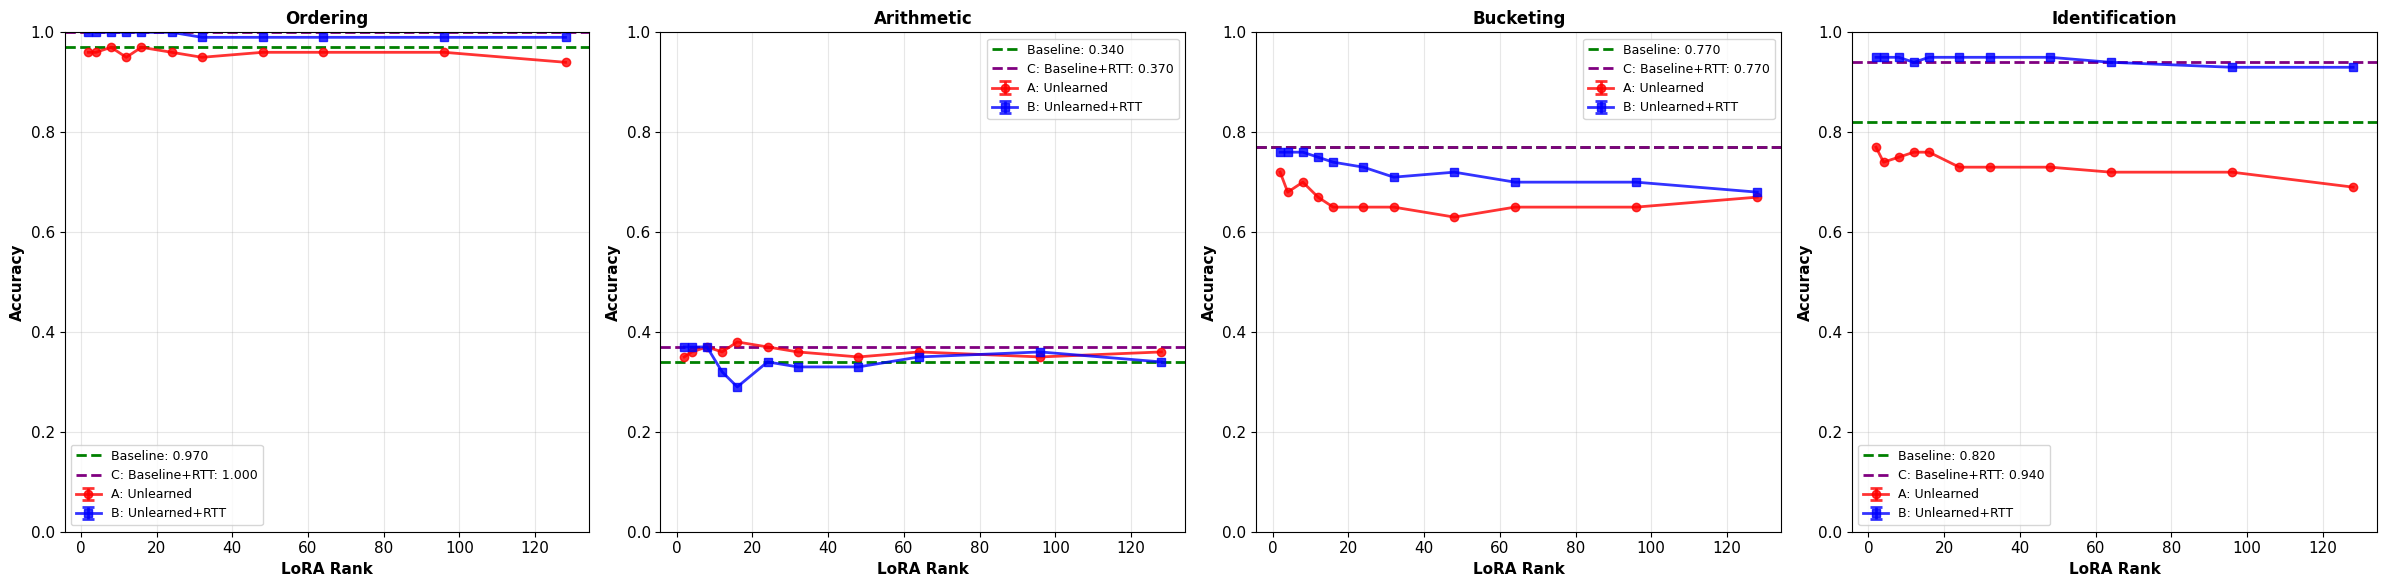

In [28]:
def plot_metric_breakdown(
    df: pd.DataFrame,
    save_path: Optional[str] = None,
    include_rtt: bool = True,
):
    if df.empty:
        print("No data to plot")
        return

    has_boundary = "boundary_acc" in df.columns
    num_plots = 4 if has_boundary else 3
    fig, axes = plt.subplots(1, num_plots, figsize=(6 * num_plots, 6))
    if num_plots == 3:
        axes = [axes[0], axes[1], axes[2]]
    else:
        axes = [axes[0], axes[1], axes[2], axes[3]]

    metrics = [
        ("ordering_acc", "Accuracy", "Ordering"),
        ("arithmetic_acc", "Accuracy", "Arithmetic"),
        ("classification_acc", "Accuracy", "Bucketing"),
    ]
    if has_boundary:
        metrics.append(("boundary_acc", "Accuracy", "Identification"))

    baseline = df[df["checkpoint_type"] == "BASELINE"]
    a_models = df[df["checkpoint_type"] == "A"].copy()
    if include_rtt:
        b_models = df[df["checkpoint_type"] == "B"].copy()
        c_models = df[df["checkpoint_type"] == "C"].copy()
    else:
        b_models = df.iloc[0:0].copy()
        c_models = df.iloc[0:0].copy()

    for idx, (metric_col, ylabel, title) in enumerate(metrics):
        ax = axes[idx]

        if len(baseline) > 0:
            baseline_acc = baseline[metric_col].mean()
            ax.axhline(
                y=baseline_acc,
                color="green",
                linestyle="--",
                linewidth=2,
                label=f"Baseline: {baseline_acc:.3f}",
            )

        if len(a_models) > 0:
            rank_stats = a_models.groupby("lora_rank")[metric_col].agg(["mean", "std"])
            ranks = rank_stats.index.values
            means = rank_stats["mean"].values
            stds = rank_stats["std"].values
            ax.errorbar(
                ranks, means, yerr=stds, marker="o", markersize=6,
                linewidth=2, capsize=4, capthick=2, color="red",
                label="A: Unlearned", alpha=0.8
            )

        if len(b_models) > 0:
            rank_stats = b_models.groupby("lora_rank")[metric_col].agg(["mean", "std"])
            ranks = rank_stats.index.values
            means = rank_stats["mean"].values
            stds = rank_stats["std"].values
            ax.errorbar(
                ranks, means, yerr=stds, marker="s", markersize=6,
                linewidth=2, capsize=4, capthick=2, color="blue",
                label="B: Unlearned+RTT", alpha=0.8
            )

        if len(c_models) > 0:
            c_acc = c_models[metric_col].mean()
            ax.axhline(
                y=c_acc,
                color="purple",
                linestyle="--",
                linewidth=2,
                label=f"C: Baseline+RTT: {c_acc:.3f}",
            )

        ax.set_xlabel("LoRA Rank", fontsize=11, fontweight="bold")
        ax.set_ylabel(ylabel, fontsize=11, fontweight="bold")
        ax.set_title(title, fontsize=12, fontweight="bold")
        ax.set_ylim(0.0, 1.0)
        ax.legend(fontsize=9, loc="best")
        ax.grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"Saved figure to {save_path}")

    plt.show()


INCLUDE_RTT = True

if not df.empty:
    plot_metric_breakdown(
        df,
        save_path=os.path.join(OUTPUT_DIR, "metric_breakdown.png"),
        include_rtt=INCLUDE_RTT,
    )
else:
    print("No data to plot. Please run evaluation first.")


## Eval cache summary plots

Load summary metrics from an eval cache JSON and plot LoRA rank vs. accuracy.


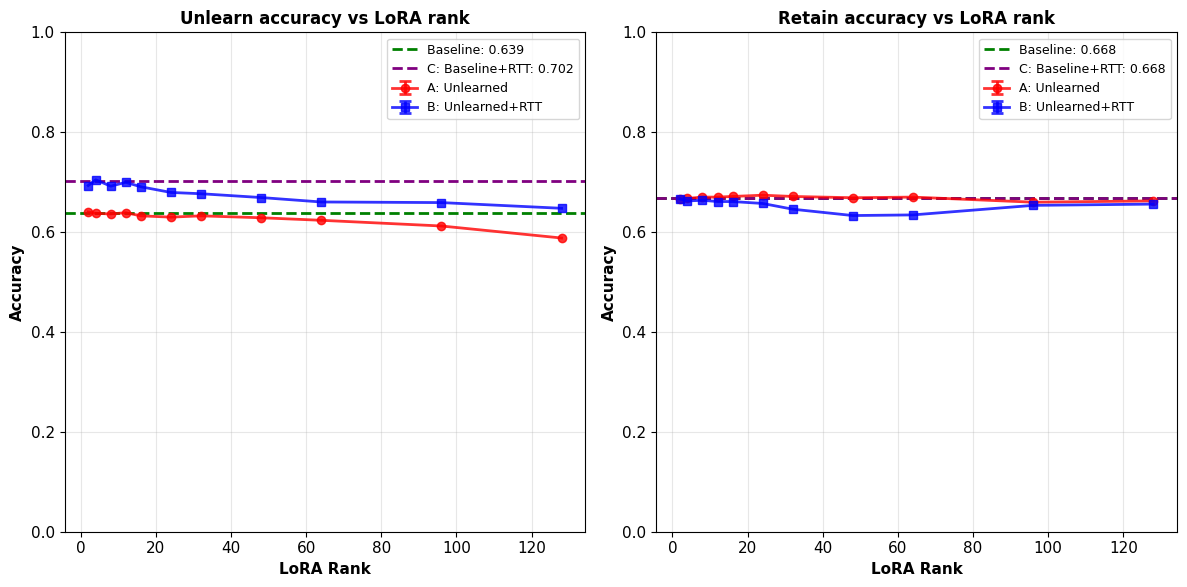

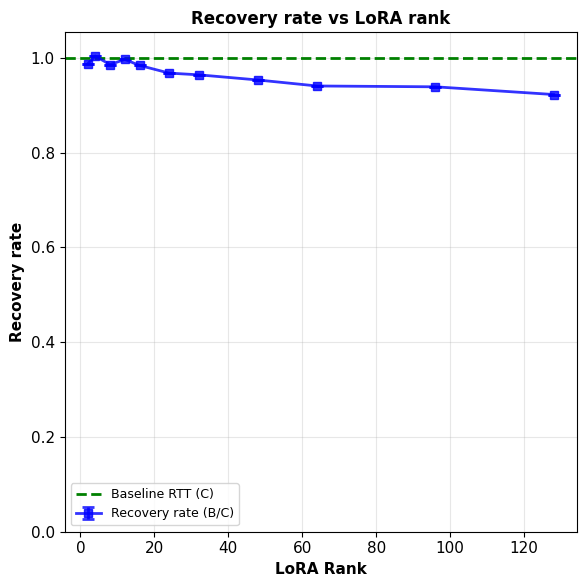

In [31]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

EVAL_CACHE_PATH = Path("evals/pipeline/summary/eval_cache_2025-12-28_05-13-18.json")

def _latest_epoch_value(epoch_dict):
    if not epoch_dict:
        return None
    # Epoch keys are strings; sort numerically to find the latest.
    last_key = max(epoch_dict.keys(), key=lambda k: float(k))
    return epoch_dict[last_key]


def _mean_metric(metric_by_file):
    values = []
    for _, epoch_dict in (metric_by_file or {}).items():
        value = _latest_epoch_value(epoch_dict or {})
        if value is not None:
            values.append(value)
    return float(np.mean(values)) if values else None


def load_eval_cache_df(path: Path) -> pd.DataFrame:
    with path.open("r") as f:
        cache = json.load(f)

    rows = []
    for group_name, entries in cache.items():
        for entry in entries:
            rows.append({
                "checkpoint_type": entry.get("type", group_name),
                "model_path": entry.get("path"),
                "lora_rank": entry.get("lora_rank"),
                "forget_acc": _mean_metric(entry.get("forget_accs")),
                "retain_acc": _mean_metric(entry.get("retain_accs")),
                "forget_acc_calibrated": _mean_metric(entry.get("forget_accs_calibrated")),
                "retain_acc_calibrated": _mean_metric(entry.get("retain_accs_calibrated")),
                "run_name": entry.get("run_name"),
                "method": entry.get("method"),
                "dataset": entry.get("dataset"),
                "project": entry.get("project"),
            })

    return pd.DataFrame(rows)


def _style_for_checkpoint(checkpoint_type: str):
    if checkpoint_type == "A":
        return {"color": "red", "marker": "o", "label": "A: Unlearned"}
    if checkpoint_type == "B":
        return {"color": "blue", "marker": "s", "label": "B: Unlearned+RTT"}
    if checkpoint_type == "C":
        return {"color": "purple", "marker": "^", "label": "C: Baseline+RTT"}
    return {"color": "black", "marker": "o", "label": checkpoint_type}


def _checkpoint_mean(df: pd.DataFrame, checkpoint_type: str, metric_col: str):
    subset = df[df["checkpoint_type"] == checkpoint_type]
    if subset.empty:
        return None
    return subset[metric_col].mean()


def _baseline_mean(df: pd.DataFrame, metric_col: str):
    return _checkpoint_mean(df, "Baseline", metric_col)


def _plot_rank_curve(ax, df: pd.DataFrame, metric_col: str, checkpoint_type: str) -> bool:
    subset = df[df["checkpoint_type"] == checkpoint_type].dropna(
        subset=["lora_rank", metric_col]
    )
    if subset.empty:
        return False

    rank_stats = subset.groupby("lora_rank")[metric_col].agg(["mean", "std"]).reset_index()
    style = _style_for_checkpoint(checkpoint_type)
    ax.errorbar(
        rank_stats["lora_rank"],
        rank_stats["mean"],
        yerr=rank_stats["std"],
        marker=style["marker"],
        markersize=6,
        linewidth=2,
        capsize=4,
        capthick=2,
        color=style["color"],
        label=style["label"],
        alpha=0.8,
    )
    return True


def _plot_c_point(ax, df: pd.DataFrame, metric_col: str):
    c_models = df[df["checkpoint_type"] == "C"].dropna(subset=[metric_col])
    if c_models.empty:
        return

    c_acc = c_models[metric_col].mean()
    style = _style_for_checkpoint("C")
    ax.axhline(
        y=c_acc,
        color=style["color"],
        linestyle="--",
        linewidth=2,
        label=f"{style['label']}: {c_acc:.3f}",
    )


def plot_lora_rank_pair(
    df: pd.DataFrame,
    metric_cols: list[str],
    titles: list[str],
    ylabels: list[str],
    checkpoint_type: str = "A",
    include_rtt: bool = True,
):
    if df.empty:
        print("No data to plot")
        return

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    for ax, metric, title, ylabel in zip(axes, metric_cols, titles, ylabels):
        baseline_value = _baseline_mean(df, metric)
        if baseline_value is not None:
            ax.axhline(
                y=baseline_value,
                color="green",
                linestyle="--",
                linewidth=2,
                label=f"Baseline: {baseline_value:.3f}",
            )

        has_any = _plot_rank_curve(ax, df, metric, checkpoint_type)
        if include_rtt:
            has_any = _plot_rank_curve(ax, df, metric, "B") or has_any
            _plot_c_point(ax, df, metric)

        if not has_any and baseline_value is None:
            print(f"No rows for {metric=} with {checkpoint_type=}")

        ax.set_xlabel("LoRA Rank", fontsize=11, fontweight="bold")
        ax.set_ylabel(ylabel, fontsize=11, fontweight="bold")
        ax.set_title(title, fontsize=12, fontweight="bold")
        ax.set_ylim(0.0, 1.0)
        ax.legend(fontsize=9, loc="best")
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def plot_recovery_rate(
    df: pd.DataFrame,
    metric_col: str = "forget_acc",
    title: str = "Recovery rate vs LoRA rank",
    ylabel: str = "Recovery rate",
    include_rtt: bool = True,
):
    if not include_rtt:
        print("Recovery rate requires RTT results; set INCLUDE_RTT=True")
        return

    baseline_rtt = _checkpoint_mean(df, "C", metric_col)
    if baseline_rtt is None or baseline_rtt <= 0:
        print("No baseline RTT data available for recovery rate")
        return

    b_models = df[df["checkpoint_type"] == "B"].dropna(subset=["lora_rank", metric_col])
    if b_models.empty:
        print("No B (Unlearned+RTT) data for recovery rate")
        return

    b_models = b_models.copy()
    b_models["recovery_rate"] = b_models[metric_col] / baseline_rtt
    stats = b_models.groupby("lora_rank")["recovery_rate"].agg(["mean", "std"]).reset_index()
    stats["std"] = stats["std"].fillna(0.0)

    style = _style_for_checkpoint("B")
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.errorbar(
        stats["lora_rank"],
        stats["mean"],
        yerr=stats["std"],
        marker=style["marker"],
        markersize=6,
        linewidth=2,
        capsize=4,
        capthick=2,
        color=style["color"],
        label="Recovery rate (B/C)",
        alpha=0.8,
    )
    ax.axhline(
        y=1.0,
        color="green",
        linestyle="--",
        linewidth=2,
        label="Baseline RTT (C)",
    )
    ax.set_xlabel("LoRA Rank", fontsize=11, fontweight="bold")
    ax.set_ylabel(ylabel, fontsize=11, fontweight="bold")
    ax.set_title(title, fontsize=12, fontweight="bold")
    upper = max(1.0, float((stats["mean"] + stats["std"]).max() + 0.05))
    ax.set_ylim(0.0, upper)
    ax.legend(fontsize=9, loc="best")
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


eval_df = load_eval_cache_df(EVAL_CACHE_PATH)
eval_df.head()

INCLUDE_RTT = True

plot_lora_rank_pair(
    eval_df,
    metric_cols=["forget_acc", "retain_acc"],
    titles=["Unlearn accuracy vs LoRA rank", "Retain accuracy vs LoRA rank"],
    ylabels=["Accuracy", "Accuracy"],
    include_rtt=INCLUDE_RTT,
)

plot_recovery_rate(
    eval_df,
    metric_col="forget_acc",
    include_rtt=INCLUDE_RTT,
)
